# ✋✂️🧻 : ResNet Transfer Learning with Rock-Paper-Scissors Dataset

This notebook demonstrates transfer learning using ResNet50V2 on the Rock-Paper-Scissors dataset from TensorFlow Datasets.

### Install and Import Required Libraries

In [11]:
!pip install tensorflow-datasets -q

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

import random
import tensorflow_datasets as tfds

### Load the Dataset

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.MW8VVW_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.MW8VVW_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author 

### Normalize and Batch the Data

In [3]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

batch_size = 64

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

### Define the Transfer Learning Model

In [4]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Resizing(300, 300),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 10, 10, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

### Train the Model

In [5]:
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 577ms/step - accuracy: 0.6337 - loss: 0.8758 - val_accuracy: 0.7473 - val_loss: 0.5432
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 427ms/step - accuracy: 0.9739 - loss: 0.2529 - val_accuracy: 0.7876 - val_loss: 0.4360
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 430ms/step - accuracy: 0.9906 - loss: 0.1457 - val_accuracy: 0.7876 - val_loss: 0.4110
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 445ms/step - accuracy: 0.9913 - loss: 0.1069 - val_accuracy: 0.7903 - val_loss: 0.4033
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 436ms/step - accuracy: 0.9948 - loss: 0.0812 - val_accuracy: 0.7957 - val_loss: 0.4014
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 439ms/step - accuracy: 0.9977 - loss: 0.0650 - val_accuracy: 0.7769 - val_loss: 0.4454
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 441ms/step - accuracy: 0.9967 - loss: 0.0579 - val_accuracy: 0.7984 - val_loss: 0.4108
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 447ms/step - accuracy: 0.9955 - loss: 0.0491 - val_accu

- Model is Slightly overfitting with accuracy close to 99.89% and val_accuracy 79.03%.


### Visualize Training Results

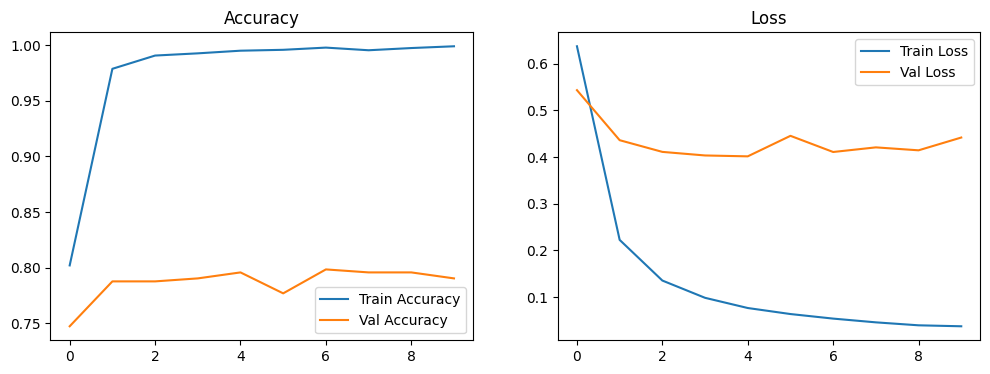

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

### Evaluate on Test Set

In [10]:
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.7969 - loss: 0.4363
Test Accuracy: 0.7903, Test Loss: 0.4418


### Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


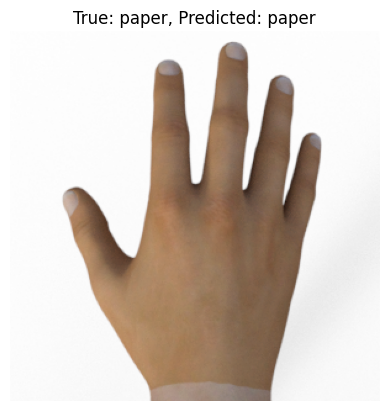

In [13]:
# Load test data again without batching
raw_test_ds = tfds.load('rock_paper_scissors', split='test', as_supervised=True)

# Pick a random test sample
sample_list = list(raw_test_ds)
sample_image, sample_label = random.choice(sample_list)

# Preprocess image
input_image = tf.image.resize(sample_image, (300, 300)) / 255.0
input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension

# Predict
pred = model.predict(input_image)
predicted_class = tf.argmax(pred[0]).numpy()

# Class labels
class_names = ds_info.features['label'].names

# Display
plt.imshow(sample_image)
plt.title(f"True: {class_names[sample_label]}, Predicted: {class_names[predicted_class]}")
plt.axis('off')
plt.show()